In [ ]:
! pip install tensorflow
! pip install matplotlib
! pip install seaborn
! pip install scikit-learn

In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [16]:
# Set the directory path
data_dir = r"C:\Users\B Vasundhara\Downloads\Mid-model Exam\Mid-model Exam\horse-or-human\horse-or-human"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [17]:
# Step 1: Load and preprocess the dataset
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 822 images belonging to 2 classes.
Found 205 images belonging to 2 classes.


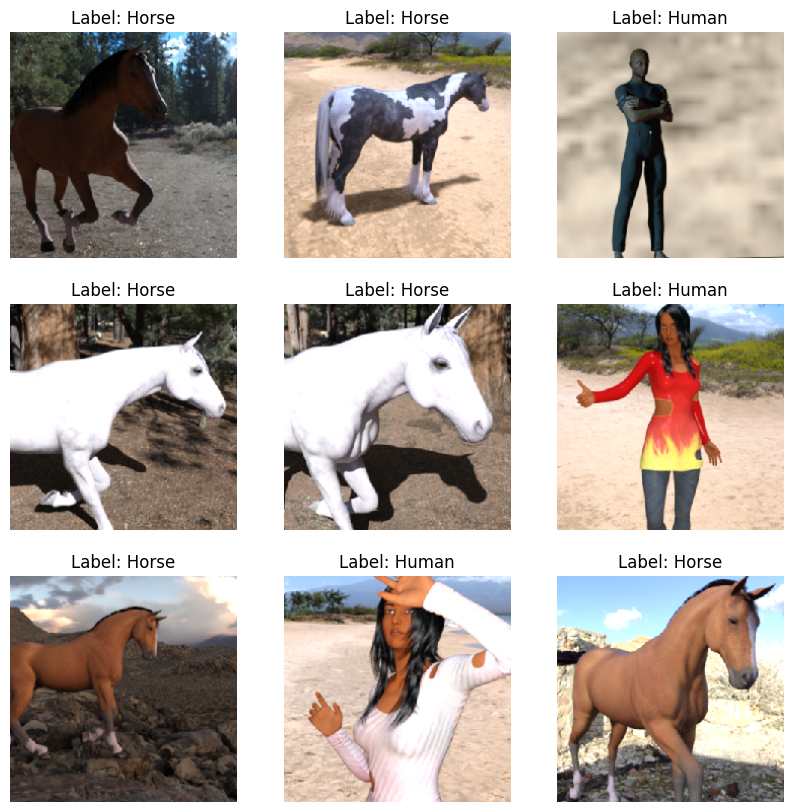

In [18]:
# Step 2: Visualize some samples
def visualize_samples(data_gen):
    images, labels = next(data_gen)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title("Label: " + ("Human" if labels[i] else "Horse"))
        plt.axis("off")
    plt.show()

visualize_samples(train_generator)

In [19]:
# Step 3: Define a function to create models with a pre-trained base
def build_pretrained_model(base_model, learning_rate=0.001):
    base_model.trainable = False  # Freeze the base model layers
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),  # Experiment with this layer size
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [23]:
# Step 4: Load and compile two pre-trained models
# VGG16
vgg_base = VGG16(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
vgg_model = build_pretrained_model(vgg_base, learning_rate=0.001)

# ResNet50
resnet_base = ResNet50(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
resnet_model = build_pretrained_model(resnet_base, learning_rate=0.001)

94765736/94765736 [==============================] - 11s 0us/step


In [24]:
# Step 5: Train both models
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [25]:
# ResNet50 training
history_resnet = resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    callbacks=[early_stop]
)

Epoch 1/5
26/26 [==============================] - 68s 2s/step - loss: 0.7436 - accuracy: 0.5134 - val_loss: 0.6993 - val_accuracy: 0.4976
Epoch 2/5
26/26 [==============================] - 59s 2s/step - loss: 0.6157 - accuracy: 0.6144 - val_loss: 0.6487 - val_accuracy: 0.5854
Epoch 3/5
26/26 [==============================] - 59s 2s/step - loss: 0.5675 - accuracy: 0.7238 - val_loss: 0.6190 - val_accuracy: 0.6293
Epoch 4/5
26/26 [==============================] - 59s 2s/step - loss: 0.5209 - accuracy: 0.7786 - val_loss: 0.5908 - val_accuracy: 0.6780
Epoch 5/5
26/26 [==============================] - 58s 2s/step - loss: 0.4874 - accuracy: 0.7944 - val_loss: 0.5903 - val_accuracy: 0.5610


In [26]:
# VGG16 training
history_vgg = vgg_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    callbacks=[early_stop]
)

Epoch 1/5
26/26 [==============================] - 112s 4s/step - loss: 0.4988 - accuracy: 0.8139 - val_loss: 0.5254 - val_accuracy: 0.7951
Epoch 2/5
26/26 [==============================] - 112s 4s/step - loss: 0.2461 - accuracy: 0.9757 - val_loss: 0.5008 - val_accuracy: 0.7317
Epoch 3/5
26/26 [==============================] - 107s 4s/step - loss: 0.1394 - accuracy: 0.9842 - val_loss: 0.4463 - val_accuracy: 0.8146
Epoch 4/5
26/26 [==============================] - 111s 4s/step - loss: 0.0961 - accuracy: 0.9878 - val_loss: 0.5910 - val_accuracy: 0.7171
Epoch 5/5
26/26 [==============================] - 107s 4s/step - loss: 0.0633 - accuracy: 0.9915 - val_loss: 0.4996 - val_accuracy: 0.7707


In [ ]:
# Step 6: Fine-tune the pretrained models (unfreeze some layers and retrain)
def fine_tune_model(model, base_model, learning_rate=1e-5):
    base_model.trainable = True  # Unfreeze all layers for fine-tuning
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Fine-tune VGG16
vgg_model = fine_tune_model(vgg_model, vgg_base)
history_vgg_finetuned = vgg_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    callbacks=[early_stop]
)

In [ ]:
# Fine-tune ResNet50
resnet_model = fine_tune_model(resnet_model, resnet_base)
history_resnet_finetuned = resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    callbacks=[early_stop]
)

In [35]:
# Step 7: Evaluate both models on the test set and report results
def evaluate_model(model, test_generator):
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    # Confusion matrix and classification report
    predictions = (model.predict(test_generator) > 0.5).astype("int32")
    true_labels = test_generator.classes
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Horse", "Human"], yticklabels=["Horse", "Human"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    print(classification_report(true_labels, predictions, target_names=["Horse", "Human"]))


In [36]:
# Load test data
test_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 205 images belonging to 2 classes.


VGG16 Evaluation:
7/7 [==============================] - 25s 3s/step - loss: 0.4996 - accuracy: 0.7707
Test Loss: 0.4995780289173126
Test Accuracy: 0.7707316875457764
7/7 [==============================] - 25s 3s/step


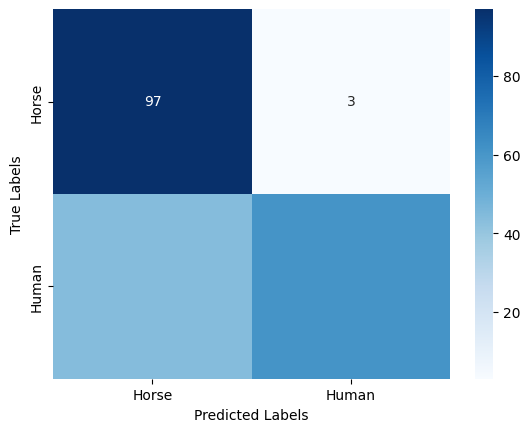

              precision    recall  f1-score   support

       Horse       0.69      0.97      0.80       100
       Human       0.95      0.58      0.72       105

    accuracy                           0.77       205
   macro avg       0.82      0.78      0.76       205
weighted avg       0.82      0.77      0.76       205

ResNet50 Evaluation:
7/7 [==============================] - 12s 2s/step - loss: 0.5903 - accuracy: 0.5610
Test Loss: 0.5902726054191589
Test Accuracy: 0.5609756112098694
7/7 [==============================] - 12s 2s/step


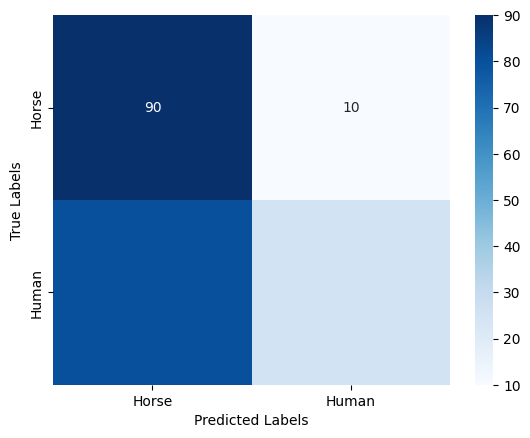

              precision    recall  f1-score   support

       Horse       0.53      0.90      0.67       100
       Human       0.71      0.24      0.36       105

    accuracy                           0.56       205
   macro avg       0.62      0.57      0.51       205
weighted avg       0.62      0.56      0.51       205



In [37]:
print("VGG16 Evaluation:")
evaluate_model(vgg_model, test_generator)

print("ResNet50 Evaluation:")
evaluate_model(resnet_model, test_generator)

In [31]:
# Step 8: Print model summaries
print("VGG16 Model Summary:")
vgg_model.summary()

print("\nResNet50 Model Summary:")
resnet_model.summary()

VGG16 Model Summary:
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 128)               65664     
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 14780481 (56.38 MB)
Trainable params: 65793 (257.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________

ResNet50 Model Summary:
Model: "sequential_6"
______